In [68]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import datetime

In [69]:
# S&P ETF STOCKS
# stocks = [
#     #"XLC",
#     "XLY",
#     "XLP",
#     "XLE",
#     "XLF",
#     "XLV",
#     "XLI",
#     "XLB",
#     #"XLRE",
#     "XLK",
#     "XLU"]

# CRACKED S&P STOCKS
# stocks = [
#     "AAPL",  # Apple Inc.
#     "MSFT",  # Microsoft Corporation
#     "JNJ",   # Johnson & Johnson
#     "PG",    # Procter & Gamble Co.
#     "JPM",   # JPMorgan Chase & Co.
#     "VZ",    # Verizon Communications Inc.
#     "PFE",   # Pfizer Inc.
#     "KO",    # The Coca-Cola Company
#     "DIS",   # The Walt Disney Company
#     "PEP"    # PepsiCo, Inc.
# # ]

stocks = [
    "NKE",  # Nike (for Adidas)
    "JPM",  # JPMorgan Chase (for Banca Intesa)
    "PFE",  # Pfizer (for Bayer)
    "WFC",  # Wells Fargo (for BBVA)
    "C",    # Citigroup (for BNP Paribas)
    "WMT",  # Walmart (for Carrefour)
    "VZ",   # Verizon (for Deutsche Telekom)
    "GM",   # General Motors (for Daimler)
    "BAC",  # Bank of America (for Deutsche Bank)
    "NEE",  # NextEra Energy (for Enel)
    "DUK",  # Duke Energy (for Engie)
    "XOM",  # ExxonMobil (for Eni)
    "PRU",  # Prudential Financial (for Generali)
    "EL",   # Estée Lauder (for L'Oreal)
    "RL",   # Ralph Lauren (for LVMH)
    "CSCO", # Cisco (for Nokia)
    "T",    # AT&T (for Orange)
    "GE",   # General Electric (for Philips)
    "LMT",  # Lockheed Martin (for Safran)
    "MRK",  # Merck (for Sanofi)
    "PNC",  # PNC Financial Services (for Santander)
    "ORCL", # Oracle (for SAP)
    "HON",  # Honeywell (for Schneider Electric)
    "RTX",  # Raytheon Technologies (for Siemens)
    "TMUS", # T-Mobile US (for Telefonica)
    "CVX",  # Chevron (for Total)
    "PG",   # Procter & Gamble (for Unilever)
]


test_date = "2018-01-01"
initial_capital = 1000
rebalance_per_year = 12

In [26]:
# check if stock exists on dec 1 2014

for stock in stocks:
    try:
        # Download historical data for the stock
        data = yf.download(stock, start="2014-12-01", end="2025-12-02")

        # Check if data exists for December 1st, 2014
        if data.empty:
            print(f"No data found for {stock} on December 1st, 2014")
    except Exception as e:
        print(f"Error downloading data for {stock}: {e}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# T-Bills

In [70]:
def fetch_1m_tbill_from_fred(series="DTB3"):
    """
    Fetch the 1-month Treasury yield from FRED using pandas_datareader.
    Common series:
      - 'DGS1MO': 1-Month Treasury Constant Maturity Rate
      - 'DTB4WK': 4-Week T-Bill Secondary Market Rate
    """
    end = datetime.date.today()
    start = end.replace(end.year - 10)  # 10 years ago
    # Use DataReader, specifying 'fred' as the data source:
    df = web.DataReader(series, "fred", start, end)

    # Rename the column to something more descriptive
    df.columns = ["3M_Treasury"]

    df["3M_Treasury"] = df["3M_Treasury"] / 100  # Convert to decimal

    df.index.name = "Date"
    df.reset_index(inplace=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.tz_localize(None)

    # Reset index so Date becomes a column
    df.reset_index(inplace=True)

    return df

tb1m_data = fetch_1m_tbill_from_fred()
print(tb1m_data.head())

   index       Date  3M_Treasury
0      0 2015-03-11       0.0003
1      1 2015-03-12       0.0003
2      2 2015-03-13       0.0003
3      3 2015-03-16       0.0005
4      4 2015-03-17       0.0005


# Fetch Data

In [71]:
def fetch_stocks_data(tickers):
    """
    Fetch historical data (e.g. 'Close' prices) for multiple tickers
    between start_date and end_date, and return a single DataFrame
    merged on the Date index.
    """

    end_date = datetime.date.today()
    start_date = end_date.replace(end_date.year - 10)  # 10 years ago
    # This will hold individual DataFrames for each ticker
    data_frames = []

    for ticker in tickers:
        # Download the data for the current ticker
        df = yf.download(ticker, start=start_date, end=end_date)

        # Keep only 'Close' (or 'Adj Close' if you prefer adjusted prices)
        df = df[['Close']]

        # Rename the column from 'Close' to the ticker symbol
        df.columns = [ticker]

        # Append to our list
        data_frames.append(df)

    # Concatenate all DataFrames side by side (axis=1)
    merged_df = pd.concat(data_frames, axis=1)
    merged_df = merged_df.reset_index()
    merged_df['Date'] = pd.to_datetime(merged_df['Date'])

    # Optional: drop rows with all NaNs (if some tickers have missing data on certain dates)
    merged_df.dropna(how='all', inplace=True)

    return merged_df

def process_stock_data(df, stocks):
    for stock in stocks:
        # 1) Compute the daily log return:
        df[f'{stock}_daily_return'] = np.log(df[stock]) - np.log(df[stock].shift(1))

        # 2) Compute a rolling 1-year (252 trading days) mean of past daily returns.
        #    The .shift(1) ensures we only use *past* data (i.e., up to yesterday),
        #    avoiding look-ahead bias.
        df[f'{stock}_rolling_mean_return'] = (
            df[f'{stock}_daily_return']
            .rolling(window=252)
            .mean()
            .shift(1)
        )

        # 3) Center today's daily return by subtracting the *past* 1-year mean:
        df[f'{stock}_daily_return_centered'] = (
            df[f'{stock}_daily_return']
            - df[f'{stock}_rolling_mean_return']
        )

        # 4) (Optional) Use the *centered* daily returns if you want a “zero-mean” series
        #    for log-growth or Kelly derivations:
        df[f'{stock}_annual_return_centered'] = (
            df[f'{stock}_daily_return_centered']
            .rolling(window=252)
            .sum()
        )
        df[f'{stock}_log_volatility_centered'] = (
            df[f'{stock}_daily_return_centered']
            .rolling(window=252)
            .std()
            * np.sqrt(252)
        )

    # Convert 'Date' to datetime and set as index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    return df

# Calculates all the past returns, variances, etc. for a set of tickers
def fetch_and_process_stocks(stocks):
    datas = fetch_stocks_data(stocks)
    processed_data = process_stock_data(datas, stocks)

    # --- Merge FRED data into processed_data ---
    tb_data = fetch_1m_tbill_from_fred()

    # Ensure tb_data has Date as the index
    tb_data.set_index("Date", inplace=True)
    tb_data.sort_index(inplace=True)

    # Join the T-Bill column into processed_data (which has Date as its index)
    processed_data = processed_data.join(tb_data[["3M_Treasury"]], how="left")

    # Forward fill missing T-Bill rates
    processed_data["3M_Treasury"] = processed_data["3M_Treasury"].ffill()

    return processed_data

In [72]:
if __name__ == "__main__":
    result = fetch_and_process_stocks(stocks)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [73]:
result.head()

,NKE,JPM,PFE,WFC,C,WMT,VZ,GM,BAC,NEE,...,CVX_rolling_mean_return,CVX_daily_return_centered,CVX_annual_return_centered,CVX_log_volatility_centered,PG_daily_return,PG_rolling_mean_return,PG_daily_return_centered,PG_annual_return_centered,PG_log_volatility_centered,3M_Treasury
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-11,42.400417,45.755821,21.349255,40.348564,39.789654,22.151976,28.671326,29.637428,13.037973,18.953817,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0003
2015-03-12,43.156456,46.614117,21.584137,41.768661,41.120296,22.484159,29.302723,30.147324,13.021784,19.445169,...,NaN,NaN,NaN,NaN,0.008564,NaN,NaN,NaN,NaN,0.0003
2015-03-13,42.609440,46.333084,21.584137,41.580818,40.709682,22.484159,29.368874,29.849236,13.021784,19.462582,...,NaN,NaN,NaN,NaN,-0.003172,NaN,NaN,NaN,NaN,0.0003
2015-03-16,42.889614,46.978706,21.863462,41.873863,40.823750,22.865761,29.627441,30.264994,13.054157,19.919115,...,NaN,NaN,NaN,NaN,0.020921,NaN,NaN,NaN,NaN,0.0005
2015-03-17,42.934090,46.796425,21.692055,42.009102,40.937794,22.681824,29.435022,30.037487,13.021784,19.979082,...,NaN,NaN,NaN,NaN,-0.008533,NaN,NaN,NaN,NaN,0.0005


# Kelly

In [103]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Kelly optimization function as provided:
def kelly_optimize(M, Sigma, r=0.0):
    """
    Solve the constrained Kelly portfolio optimization:
      Maximize g(F) = r + F^T (M - r) - 0.5 * F^T Sigma F
    subject to: sum(F) <= 1,  and  0 <= F_i <= 1.

    Parameters
    ----------
    M : ndarray of shape (n,)
        The annualized *expected returns* of the n risky assets.
    Sigma : ndarray of shape (n, n)
        The annualized covariance matrix of the n assets.
    r : float
        The risk-free rate (annualized). Default=0.0.

    Returns
    -------
    F_opt : ndarray of shape (n,)
        The optimal weights for each of the n risky assets (no short, no leverage).
    max_g : float
        The maximum value of the Kelly objective at F_opt.
    """
    n = len(M)

    def neg_kelly_objective(F):
        M_ex = M - r
        linear_term = np.dot(F, M_ex)
        quad_term = 0.5 * np.dot(F, Sigma @ F)
        gF = r + linear_term - quad_term
        return -gF

    constraints = [{'type': 'ineq', 'fun': lambda F: 1.0 - np.sum(F)}]
    bounds = [(0, 1.0)] * n
    x0 = np.full(n, 1.0 / n)

    res = minimize(fun=neg_kelly_objective, x0=x0, method='SLSQP',
                   bounds=bounds, constraints=constraints)
    # if not res.success:
    #     raise ValueError("Optimization failed: " + res.message)

    # F_opt = res.x
    # g_opt = -res.fun

    if not res.success:
        print(f"[WARNING] Optimization failed: {res.message}")
        # Option 1: Return the partial solution anyway:
        F_opt = res.x
        g_opt = -res.fun
        # Option 2 (safer): Return zeros or some default:
        # F_opt = np.zeros(n)
        # g_opt = float('nan')
    else:
        F_opt = res.x
        g_opt = -res.fun
    return F_opt, g_opt

# Monthly summary function that uses pct_change(periods=252) for annual return.
def monthly_cov_summary(df, stocks, window=252):
    """
    For each month-start in 'df', compute:
      - The annual return for each stock: price[t] / price[t-252] - 1
      - The annual variance for each stock (daily variance * 252)
      - The NxN annual covariance matrix (daily covariance * 252)

    Returns a new DataFrame with one row per month-start, including:
      <stock>_annual_return, <stock>_annual_variance, and annual_cov_matrix.
    """
    # Identify the daily-return columns (assumed already computed in df)
    # return_cols = [f"{s}_daily_return" for s in stocks]
    return_cols = [f"{s}_daily_return" for s in stocks]
    summary_data = []
    # Identify month-start dates (earliest trading day in each month)
    month_starts = df.resample("MS").first().dropna(how="all").index

    for date in month_starts:
        if date not in df.index:
            idx_pos = df.index.searchsorted(date)
            if idx_pos >= len(df.index):
                break
            date = df.index[idx_pos]

        i = df.index.get_loc(date)
        if i < window:
            continue

        # 252-day look-back window: rows i-window to i-1.
        lookback_df = df.iloc[i - window : i]
        row_result = {}
        row_result["month_start"] = date

        # For each stock, calculate annual return using price[t] / price[t-252] - 1,
        # and annual variance from daily variance * 252.
        for stock in stocks:
            price_current = df.loc[date, stock]
            price_252_ago = df[stock].iloc[i - window]
            row_result[f"{stock}_annual_return"] = price_current / price_252_ago - 1
            daily_ret_col = f"{stock}_daily_return"
            row_result[f"{stock}_annual_variance"] = lookback_df[daily_ret_col].var() * 252

        # Annual covariance matrix computed over the lookback window.
        daily_cov = lookback_df[return_cols].cov().values
        row_result["annual_cov_matrix"] = daily_cov * 252
        summary_data.append(row_result)

    summary_df = pd.DataFrame(summary_data)
    summary_df.set_index("month_start", inplace=True)
    return summary_df

# NEW: compute_kelly_weights function.
def compute_kelly_weights(data, stocks, end_date, window=252, should_print=False):
    """
    Compute Kelly weights using the past 'window' trading days up to end_date.

    The function extracts the subdata from the full DataFrame (which must be indexed by date)
    and computes:
      - Annual returns: using first and last prices in the window.
      - The annual covariance matrix from the daily returns.
      - The risk-free rate at end_date.
    Then it calls kelly_optimize to obtain the optimal weights.
    """
    # Extract the last 'window' rows (trading days) up to end_date.
    subdata = data.loc[:end_date].iloc[-window:]
    # Debug print (optional)
    if should_print:
      print("In compute_kelly_weights: len(subdata) =", len(subdata), "window =", window)
      print(subdata.index[0], subdata.index[-1])
    if len(subdata) < window:
        raise ValueError("Not enough data for the window")

    annual_returns = []
    for stock in stocks:
        p_first = subdata[stock].iloc[0]
        p_last = subdata[stock].iloc[-1]
        ann_return = p_last / p_first - 1
        annual_returns.append(ann_return)

    daily_returns = subdata[[f"{stock}_daily_return" for stock in stocks]]
    Sigma = daily_returns.cov().values * 252
    try:
        r = data.loc[end_date, "3M_Treasury"]
    except KeyError:
        r = data["3M_Treasury"].iloc[-1]
    M = np.array(annual_returns)
    F_opt, _ = kelly_optimize(M, Sigma, r)
    return F_opt, r


In [104]:
def monthly_kelly_summary(df, stocks, window=252):
    """
    For each month (using monthly_cov_summary), compute the optimal Kelly weights.
    Uses the risk‐free rate from the '3M_Treasury' column at the month start.
    """
    summary_df = monthly_cov_summary(df, stocks, window)
    kelly_weights = []
    kelly_obj_vals = []
    risk_free_rates = []

    for date, row in summary_df.iterrows():
        # Construct the expected returns vector M
        M = np.array([row[f"{stock}_annual_return"] for stock in stocks])
        # Get the annual covariance matrix Sigma
        Sigma = row["annual_cov_matrix"]
        try:
            r = df.loc[date, "3M_Treasury"]
        except KeyError:
            r = df["3M_Treasury"].iloc[-1]
        risk_free_rates.append(r)
        F_opt, g_opt = kelly_optimize(M, Sigma, r)
        kelly_weights.append(F_opt)
        kelly_obj_vals.append(g_opt)

    summary_df["kelly_weights"] = kelly_weights
    summary_df["kelly_obj"] = kelly_obj_vals
    summary_df["risk_free_rate"] = risk_free_rates
    return summary_df

processed_data = fetch_and_process_stocks(stocks)
monthly_kelly_df = monthly_kelly_summary(processed_data, stocks=stocks, window=252)
# print(monthly_kelly_df.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [105]:
test_df = monthly_kelly_df[monthly_kelly_df.index > test_date]
test_df.head()

,NKE_annual_return,NKE_annual_variance,JPM_annual_return,JPM_annual_variance,PFE_annual_return,PFE_annual_variance,WFC_annual_return,WFC_annual_variance,C_annual_return,C_annual_variance,...,TMUS_annual_return,TMUS_annual_variance,CVX_annual_return,CVX_annual_variance,PG_annual_return,PG_annual_variance,annual_cov_matrix,kelly_weights,kelly_obj,risk_free_rate
month_start,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.265738,0.046866,0.279559,0.026214,0.166057,0.012472,0.139942,0.031364,0.269413,0.030702,...,0.113546,0.051380,0.127009,0.019794,0.111865,0.011571,"[[0.04686607114509567, 0.0044520823087695945, ...","[0.0, 9.052706759316064e-17, 0.0, 0.0, 0.0, 0....",0.675278,0.0142
2018-02-01,0.292965,0.048619,0.406689,0.024560,0.207575,0.015048,0.203938,0.029114,0.433570,0.028671,...,0.008378,0.047069,0.176208,0.021453,0.013501,0.011787,"[[0.04861914724191405, 0.004624712890501339, 0...","[0.0, 1.1479917744178546e-15, 0.0, 0.0, 0.0, 0...",0.690921,0.0146
2018-03-01,0.159711,0.055895,0.239111,0.031019,0.074893,0.021029,-0.014120,0.041276,0.215795,0.033469,...,-0.007058,0.049489,0.023320,0.030301,-0.114799,0.014922,"[[0.05589533544021629, 0.01249119158646136, 0....","[4.1514937192130043e-16, 0.0, 0.0, 0.0, 0.0, 0...",0.651806,0.0160
2018-04-02,0.159350,0.051457,0.238632,0.034185,0.059551,0.023291,-0.061831,0.044167,0.136611,0.037219,...,-0.084600,0.050807,0.083167,0.032682,-0.115329,0.016226,"[[0.05145650083781537, 0.01464389217666203, 0....","[2.502077276330624e-16, 2.0122792321330962e-16...",0.734421,0.0174
2018-05-01,0.254824,0.057188,0.276725,0.035814,0.088188,0.024989,-0.008338,0.044349,0.162803,0.038153,...,-0.129995,0.058121,0.226115,0.035070,-0.146787,0.017671,"[[0.057187869123654235, 0.017314264683277434, ...","[5.374851250278032e-16, 0.0, 1.053360042192904...",0.665249,0.0182


# Markowitz

In [77]:
# data = fetch_stocks_data(stocks)
# print("Fetched columns:", data.columns)


In [78]:
def markowitz_max_sharpe(M, Sigma, r=0.0):
    """
    Solve for weights w that maximize the Sharpe ratio:
      Sharpe(w) = (M - r)^T w / sqrt(w^T Sigma w)
    subject to: 0 <= w_i <= 1, and sum(w) <= 1.

    Parameters
    ----------
    M : ndarray of shape (n,)
        Annualized expected returns for n assets.
    Sigma : ndarray of shape (n, n)
        Annualized covariance matrix for the n assets.
    r : float
        Risk-free rate (annualized).

    Returns
    -------
    w_opt : ndarray of shape (n,)
        Optimal weights for each asset.
    max_sr : float
        Maximum Sharpe ratio achieved.
    """
    n = len(M)
    M_ex = M - r  # excess returns

    def neg_sharpe(w):
        ret = np.dot(M_ex, w)
        vol = np.sqrt(np.dot(w, np.dot(Sigma, w)))
        if vol < 1e-12:
            return 1e10
        return -(ret / vol)  # negative because we minimize

    cons = [{'type': 'ineq', 'fun': lambda w: 1.0 - np.sum(w)}]  # ensures sum(w) <= 1
    bnds = [(0.0, 1)] * n  # each w_i between 0 and 1
    w0 = np.full(n, 1.0 / n)

    res = minimize(fun=neg_sharpe, x0=w0, method='SLSQP', bounds=bnds, constraints=cons)
    # if not res.success:
    #     raise ValueError("Sharpe maximization failed: " + res.message)

    # w_opt = res.x
    # max_sr = -res.fun
    if not res.success:
        print(f"[WARNING] Sharpe maximization failed: {res.message}")
        # Option 1: Return the partial solution from 'res.x'
        w_opt = res.x
        max_sr = float('nan')  # we don't trust the objective if constraints failed
        # Option 2 (instead): Return all zeros or some default fallback
        # w_opt = np.zeros(n)
        # max_sr = float('nan')
    else:
        w_opt = res.x
        max_sr = -res.fun
    return w_opt, max_sr

In [79]:
def monthly_markowitz_summary(df, stocks, window=252, fred_series="DTB3"):
    # --- Monthly Covariance Summary ---
    return_cols = [f"{s}_daily_return" for s in stocks]
    summary_data = []
    month_starts = df.resample("MS").first().dropna(how="all").index

    for date in month_starts:
        # Ensure the date exists in df; if not, find the next available date.
        if date not in df.index:
            idx_pos = df.index.searchsorted(date)
            if idx_pos >= len(df.index):
                break
            date = df.index[idx_pos]
        i = df.index.get_loc(date)
        if i < window:
            continue  # not enough data
        lookback_df = df.iloc[i - window : i]
        row_result = {"month_start": date}
        # Compute annual return for each stock: price[t] / price[t-252] - 1
        for stock in stocks:
            price_current = df.loc[date, stock]
            price_252_ago = df.iloc[i - window][stock]
            row_result[f"{stock}_annual_return"] = price_current / price_252_ago - 1
        # Annualize the covariance matrix: daily covariance * 252
        daily_cov = lookback_df[return_cols].cov().values
        row_result["annual_cov_matrix"] = 252 * daily_cov
        summary_data.append(row_result)

    summary_df = pd.DataFrame(summary_data)
    summary_df.set_index("month_start", inplace=True)

    # --- Markowitz Optimization for Each Month ---
    markowitz_weights = []
    markowitz_sharpes = []

    for date, row in summary_df.iterrows():
        # Construct expected annual returns vector M for the stocks
        M = np.array([row[f"{stock}_annual_return"] for stock in stocks])
        Sigma = row["annual_cov_matrix"]
        # Pull the risk-free rate for this month from the merged df using the "3M_Treasury" column
        current_rf = df.loc[date, "3M_Treasury"]
        if pd.isna(current_rf):
            current_rf = 0.0
        w_opt, sr_opt = markowitz_max_sharpe(M, Sigma, r=current_rf)
        markowitz_weights.append(w_opt)
        markowitz_sharpes.append(sr_opt)

    summary_df["markowitz_weights"] = markowitz_weights
    summary_df["markowitz_sharpe"] = markowitz_sharpes
    return summary_df
def compute_markowitz_weights(data, stocks, end_date, window=252, should_print=False):
    """
    Compute Markowitz weights using the past 'window' trading days up to end_date.

    The function extracts the subdata from the full DataFrame (which must be indexed by date)
    and computes:
      - Annual returns: using first and last prices in the window.
      - The annual covariance matrix from the daily returns.
      - The risk-free rate at end_date.
    Then it calls markowitz_optimize to obtain the optimal weights.
    """
    # Extract the last 'window' rows (trading days) up to end_date.
    subdata = data.loc[:end_date].iloc[-window:]
    # Debug print (optional)
    if should_print:
      print("In compute_markowitz_weights: len(subdata) =", len(subdata), "window =", window)
      print(subdata.index[0], subdata.index[-1])
    if len(subdata) < window:
        raise ValueError("Not enough data for the window")

    annual_returns = []
    for stock in stocks:
        p_first = subdata[stock].iloc[0]
        p_last = subdata[stock].iloc[-1]
        ann_return = p_last / p_first - 1
        annual_returns.append(ann_return)

    daily_returns = subdata[[f"{stock}_daily_return" for stock in stocks]]
    Sigma = daily_returns.cov().values * 252
    try:
        r = data.loc[end_date, "3M_Treasury"]
    except KeyError:
        r = data["3M_Treasury"].iloc[-1]
    M = np.array(annual_returns)
    F_opt, _ = markowitz_max_sharpe(M, Sigma, r)
    return F_opt, r


In [80]:
  monthly_markowitz_df = monthly_markowitz_summary(processed_data, stocks, window=252, fred_series="DTB3")


In [81]:
monthly_markowitz_df.head()

,NKE_annual_return,JPM_annual_return,PFE_annual_return,WFC_annual_return,C_annual_return,WMT_annual_return,VZ_annual_return,GM_annual_return,BAC_annual_return,NEE_annual_return,...,PNC_annual_return,ORCL_annual_return,HON_annual_return,RTX_annual_return,TMUS_annual_return,CVX_annual_return,PG_annual_return,annual_cov_matrix,markowitz_weights,markowitz_sharpe
month_start,,,,,,,,,,,,,,,,,,,,,
2016-04-01,0.250123,0.019238,-0.094640,-0.076441,-0.174006,-0.119331,0.158410,-0.132076,-0.108699,0.168318,...,-0.057057,-0.026671,0.120285,-0.115011,0.243995,-0.057031,0.049573,"[[0.06230334689758886, 0.03108419847771099, 0....","[0.05359091599704562, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.872671
2016-05-02,0.194766,0.031065,-0.004206,-0.057490,-0.127343,-0.114939,0.067406,-0.061912,-0.071350,0.194767,...,-0.022122,-0.077517,0.142723,-0.072218,0.181389,-0.006778,0.043283,"[[0.06380224064018387, 0.03156288670481748, 0....","[0.0, 5.207194013773027e-10, 5.11132284790294e...",1.791769
2016-06-01,0.084029,0.023016,0.043158,-0.065777,-0.138694,-0.025442,0.076003,-0.126839,-0.096724,0.211486,...,-0.029612,-0.064304,0.113447,-0.121388,0.103002,0.034113,0.077330,"[[0.0663864885343719, 0.030961123177713067, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.834814
2016-07-01,0.022917,-0.066011,0.103611,-0.147002,-0.235303,0.043886,0.249067,-0.088021,-0.220540,0.334187,...,-0.141478,0.032012,0.161231,-0.036678,0.103156,0.139534,0.097295,"[[0.06809895455838663, 0.034231294222763185, 0...","[1.7253552318415014e-08, 1.73991981178763e-08,...",2.553668
2016-08-01,-0.028089,-0.041621,0.071243,-0.149787,-0.252184,0.056030,0.219216,0.041990,-0.187888,0.258978,...,-0.139686,0.046362,0.127123,0.095272,0.157649,0.174960,0.165082,"[[0.06810088344708425, 0.03399305633591965, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.309757


# Backtester

In [106]:
def backtest_portfolio(data, stocks, test_date, initial_capital=1000, rebalance_per_year=4, window=252,
                       markowitz=False, should_print=False):
    """
    Backtest a portfolio using Kelly (or Markowitz) weights over a period defined by test_date.
    The backtesting period runs from the window-th trading day before test_date until test_date.

    At each rebalancing date, the weights for the stocks are recalculated using a rolling window of
    'window' trading days. Any residual allocation (if the stocks' weights sum to less than 1) is
    invested in the risk-free asset, which is assumed to be available in the data as "3M_Treasury".

    Fractional shares are allowed.
    """
    test_date = pd.to_datetime(test_date)
    data = data.sort_index()
    if should_print:
        print("Data range:", data.index[0], "to", data.index[-1])
        print("Test date:", test_date)

    pos = data.index.searchsorted(test_date)
    if should_print:
        print("Position of test date in data index:", pos)
    if pos < window:
        raise ValueError("Not enough data for the window based on trading days. pos = {}, window = {}".format(pos, window))

    start_backtest = data.index[pos - window]
    if should_print:
        print("Backtest will first balance at:", data.index[pos])
        print("Backtest will start from:", start_backtest)

    data = data.loc[start_backtest:]
    dates = data.index
    end_date = dates[-1]

    rebal_dates = []
    current = test_date
    while current < end_date:
        next_date = current + pd.Timedelta(days=365.25/rebalance_per_year)
        pos_next = dates.searchsorted(next_date)
        if pos_next >= len(dates):
            break
        rebal_dates.append(dates[pos_next])
        current = dates[pos_next]

    if len(rebal_dates) == 0:
        raise ValueError("Not enough data for rebalancing dates.")
    if should_print:
        print("Rebalancing dates:", rebal_dates)

    portfolio = pd.Series(index=dates, dtype=float)

    # The full list of assets includes the stocks and the risk-free asset "3M_Treasury"
    assets = stocks + ["3M_Treasury"]

    last_rebal_date = rebal_dates[0]
    current_value = initial_capital

    # Compute initial weights for the stocks using the chosen method
    if markowitz:
        weights, _ = compute_markowitz_weights(data, stocks, last_rebal_date, window)
    else:
        weights, _ = compute_kelly_weights(data, stocks, last_rebal_date, window)

    # Allocate the leftover weight to the risk-free asset "3M_Treasury"
    rf_weight = 1 - sum(weights)
    weights = list(weights) + [rf_weight]

    # Compute initial shares for each asset using the asset's price at the rebalancing date
    shares = {asset: (current_value * weights[i]) / data.loc[last_rebal_date, asset]
              for i, asset in enumerate(assets)}
    portfolio.loc[last_rebal_date] = current_value
    if should_print:
        print("Initial weights:", weights)
        print("Initial shares:", shares)

    for i in range(1, len(rebal_dates)+1):
        next_rebal_date = rebal_dates[i] if i < len(rebal_dates) else end_date
        period = data.loc[last_rebal_date:next_rebal_date]
        for date, row in period.iterrows():
            # Sum the value over all assets, including the risk-free asset
            value = sum(shares[asset] * row[asset] for asset in assets)
            portfolio.loc[date] = value
        if next_rebal_date == end_date:
            break
        current_value = portfolio.loc[next_rebal_date]
        try:
            if markowitz:
                weights, _ = compute_markowitz_weights(data, stocks, next_rebal_date, window)
            else:
                weights, _ = compute_kelly_weights(data, stocks, next_rebal_date, window)
        except Exception as e:
            print("Warning: using previous weights due to error:", e)
        # Allocate remaining weight to risk-free asset
        rf_weight = 1 - sum(weights)
        weights = list(weights) + [rf_weight]
        shares = {asset: (current_value * weights[i]) / data.loc[next_rebal_date, asset]
                  for i, asset in enumerate(assets)}
        if should_print:
            print("Rebalance on", next_rebal_date)
            print("New weights:", weights)
            print("New shares:", shares)
        last_rebal_date = next_rebal_date

    portfolio = portfolio.sort_index()
    return portfolio


In [107]:
processed_data = fetch_and_process_stocks(stocks)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [108]:
kelly_portfolio = backtest_portfolio(processed_data, stocks, test_date, initial_capital, rebalance_per_year, window=252)
kelly_portfolio_df = kelly_portfolio.to_frame(name="Portfolio Value")
kelly_portfolio_df.tail()

,Portfolio Value
Date,
2025-03-04,2177.820019
2025-03-05,2174.497721
2025-03-06,2220.180382
2025-03-07,2252.573695
2025-03-10,2265.863202


In [109]:
mark_portfolio = backtest_portfolio(processed_data, stocks, test_date, initial_capital, rebalance_per_year, window=252, markowitz=True)
mark_portfolio_df = mark_portfolio.to_frame(name="Portfolio Value")
mark_portfolio_df.tail()

,Portfolio Value
Date,
2025-03-04,2258.419465
2025-03-05,2266.482862
2025-03-06,2250.858057
2025-03-07,2246.840560
2025-03-10,2217.576343


[*********************100%***********************]  1 of 1 completed


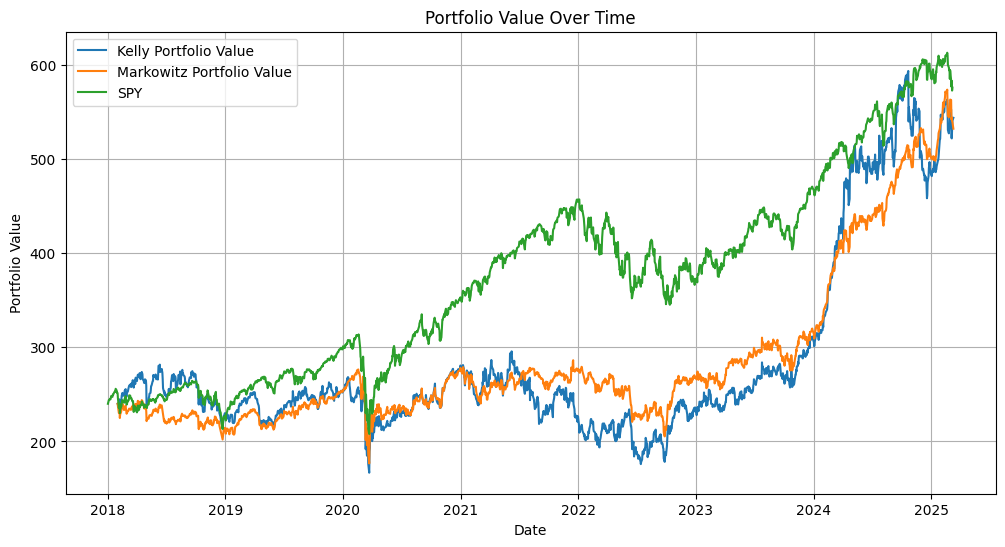

In [110]:
# generate a line graph showing this portfolio across the dates
import matplotlib.pyplot as plt

ratio = 4.166775547329582

plt.figure(figsize=(12, 6))

plt.plot(kelly_portfolio.index, kelly_portfolio.values / ratio, label='Kelly Portfolio Value')

plt.plot(mark_portfolio.index, mark_portfolio.values / ratio, label='Markowitz Portfolio Value')


# plot it vs spy

# get spy data using yfinance
import yfinance as yf
spy = yf.download('SPY', start=test_date, end=kelly_portfolio.index[-1])
plt.plot(spy.index, spy['Close'], label='SPY')

plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [111]:
kelly_portfolio = kelly_portfolio.dropna()
mark_portfolio = mark_portfolio.dropna()

In [112]:
print("Kelly", kelly_portfolio.iloc[-1] / kelly_portfolio.iloc[0] - 1)
print("Mark", mark_portfolio.iloc[-1] / mark_portfolio.iloc[0] - 1)
print("SPY", spy.iloc[-1, 0] / spy.iloc[0, 0] - 1)

Kelly 1.26586320209856
Mark 1.217576343155426
SPY 1.3997283865608567


In [113]:
# get kelly and markowitz weights for last date
kelly_weights = compute_kelly_weights(processed_data, stocks, processed_data.index[-1], window=252)[0]
mark_weights = compute_markowitz_weights(processed_data, stocks, processed_data.index[-1], window=252)[0]

#convert these weights to names of tickers, ordered by rank
kelly_weights = [(stocks[i], kelly_weights[i]) for i in np.argsort(kelly_weights)[::-1]]
mark_weights = [(stocks[i], mark_weights[i]) for i in np.argsort(mark_weights)[::-1]]

#make a table for each/pandas dataframe,
kelly_weights = pd.DataFrame(kelly_weights, columns=["Stock", "Weight"])
mark_weights = pd.DataFrame(mark_weights, columns=["Stock", "Weight"])
#convert rly low numbers to 0, make it only show like three sig figs
kelly_weights["Weight"] = kelly_weights["Weight"].apply(lambda x: round(x, 3) if x > 0.001 else 0)
kelly_weights = kelly_weights.sort_values(by="Weight", ascending=False)

mark_weights["Weight"] = mark_weights["Weight"].apply(lambda x: round(x, 3) if x > 0.001 else 0)
mark_weights = mark_weights.sort_values(by="Weight", ascending=False)

In [114]:
kelly_weights

,Stock,Weight
0,T,1.0
14,PRU,0.0
25,JPM,0.0
24,TMUS,0.0
23,WFC,0.0
22,PNC,0.0
21,WMT,0.0
20,VZ,0.0
19,GM,0.0
18,CSCO,0.0


In [115]:
mark_weights

,Stock,Weight
0,T,0.302
1,TMUS,0.236
2,RTX,0.157
3,WMT,0.154
4,ORCL,0.045
5,CSCO,0.035
6,GE,0.033
7,NEE,0.031
21,JPM,0.000
19,HON,0.000
